In [132]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
import warnings
warnings.filterwarnings('ignore')
import copy


def data_prep(start_date, end_date):
    df = yf.download('AMZN',start_date,end_date)
    APPL = yf.download('AAPL',start_date,end_date)
    MSFT = yf.download('MSFT',start_date,end_date)
    GOOG = yf.download('GOOG',start_date,end_date)
    VIX = yf.download("^VIX", start_date,end_date)
    usdx = yf.download('DX-Y.NYB', start_date,end_date)

    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df['APPL'] = APPL['Close']
    df['MSFT'] = MSFT['Close']
    df['GOOG'] = GOOG['Close']
    df['VIX'] = VIX['Close']
    df['USDX'] = usdx['Close']

    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()

    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    histogram = macd - signal

    df['EMA12'] = ema12
    df['EMA26'] = ema26
    df['MACD'] = macd
    # df['MACD_signal'] = signal
    # df['MACD_hist'] = histogram

    dff = pd.read_csv('dff.csv')
    dff['Date'] = pd.to_datetime(dff['DATE'])
    dff.drop(['DATE'],axis=1, inplace=True)
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df = pd.merge(dff, df, on='Date')

    

    print(df.info)
    df.columns = df.columns.str.replace(' ','_')
    df = df.dropna()
    dates = pd.DataFrame(df['Date'])
    df.drop(['Date'],axis=1,inplace=True)
    df.drop(['Open', 'High', 'Low', 'Adj_Close'], axis=1, inplace=True)
    y_data = df['Close']
    df_copy = copy.deepcopy(df)
    df.drop(['Close'], axis=1, inplace=True)
    X_data = df
    return X_data,y_data, dates,X_data, df_copy

start_date = '2022-04-01'
end_date = '2023-03-31'
X, y, dates,X_data,Data = data_prep(start_date, end_date)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

if X.shape[0] > 0 and y.shape[0] > 0:
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
else:
    print("Insufficient data for MinMaxScaler")

print(dates)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<bound method DataFrame.info of       DFF       Date        Open        High         Low       Close  \
0    0.33 2022-04-01  164.149506  165.826996  162.319504  163.559998   
1    0.33 2022-04-04  164.125000  168.394501  163.205505  168.346497   
2    0.33 2022-04-05  167.741501  168.110504  163.266006  164.054993   
3    0.33 2022-04-06  161.650497  162.199997  157.254501  158.755997   
4    0.33 2022-04-07  158.399994  160.078995  154.511505  157.784500   
..    ...        ...         ...         ...         ...         ...   
245  4.83 2023-03-24   98.070000   98.300003   96.

In [133]:
# dff = pd.read_csv('dff.csv')
# dff['Date'] = pd.to_datetime(dff['DATE'])
# dff.drop(['DATE'],axis=1, inplace=True)
# Data = Data.reset_index()
# Data['Date'] = pd.to_datetime(Data['Date'])
# merged_df = pd.merge(dff, Data, on='Date')

Data.describe()


,DFF,Close,Volume,APPL,MSFT,GOOG,VIX,USDX,RSI,EMA12,EMA26,MACD
count,237.000000,237.000000,2.370000e+02,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,2.907595,109.352975,7.471050e+07,148.565654,255.492996,103.930924,24.648903,105.981181,45.667346,110.691849,112.591772,-1.899923
std,1.397992,16.386302,3.105771e+07,10.319956,17.069292,10.168573,4.183672,3.287602,11.986426,16.492502,16.722859,4.185116
min,0.330000,81.820000,3.508860e+07,125.019997,214.250000,83.489998,17.870001,100.580002,18.241771,85.130379,87.810101,-13.038289
25%,1.580000,95.790001,5.522920e+07,141.860001,242.039993,95.459999,21.150000,103.599998,38.503958,96.303782,96.855440,-3.974531
50%,3.080000,107.591003,6.702980e+07,148.500000,254.080002,102.220001,24.020000,105.040001,44.728107,111.218155,113.870974,-2.154049
75%,4.330000,120.970001,8.480290e+07,154.649994,267.700012,113.084000,27.389999,108.169998,53.558891,119.259672,124.019620,0.671095
max,4.830000,148.296005,2.726620e+08,174.550003,293.470001,124.937500,34.750000,114.110001,76.659325,154.984350,158.024216,7.136492


In [134]:
print(dates)

          Date
13  2022-04-21
14  2022-04-22
15  2022-04-25
16  2022-04-26
17  2022-04-27
..         ...
245 2023-03-24
246 2023-03-27
247 2023-03-28
248 2023-03-29
249 2023-03-30

[237 rows x 1 columns]


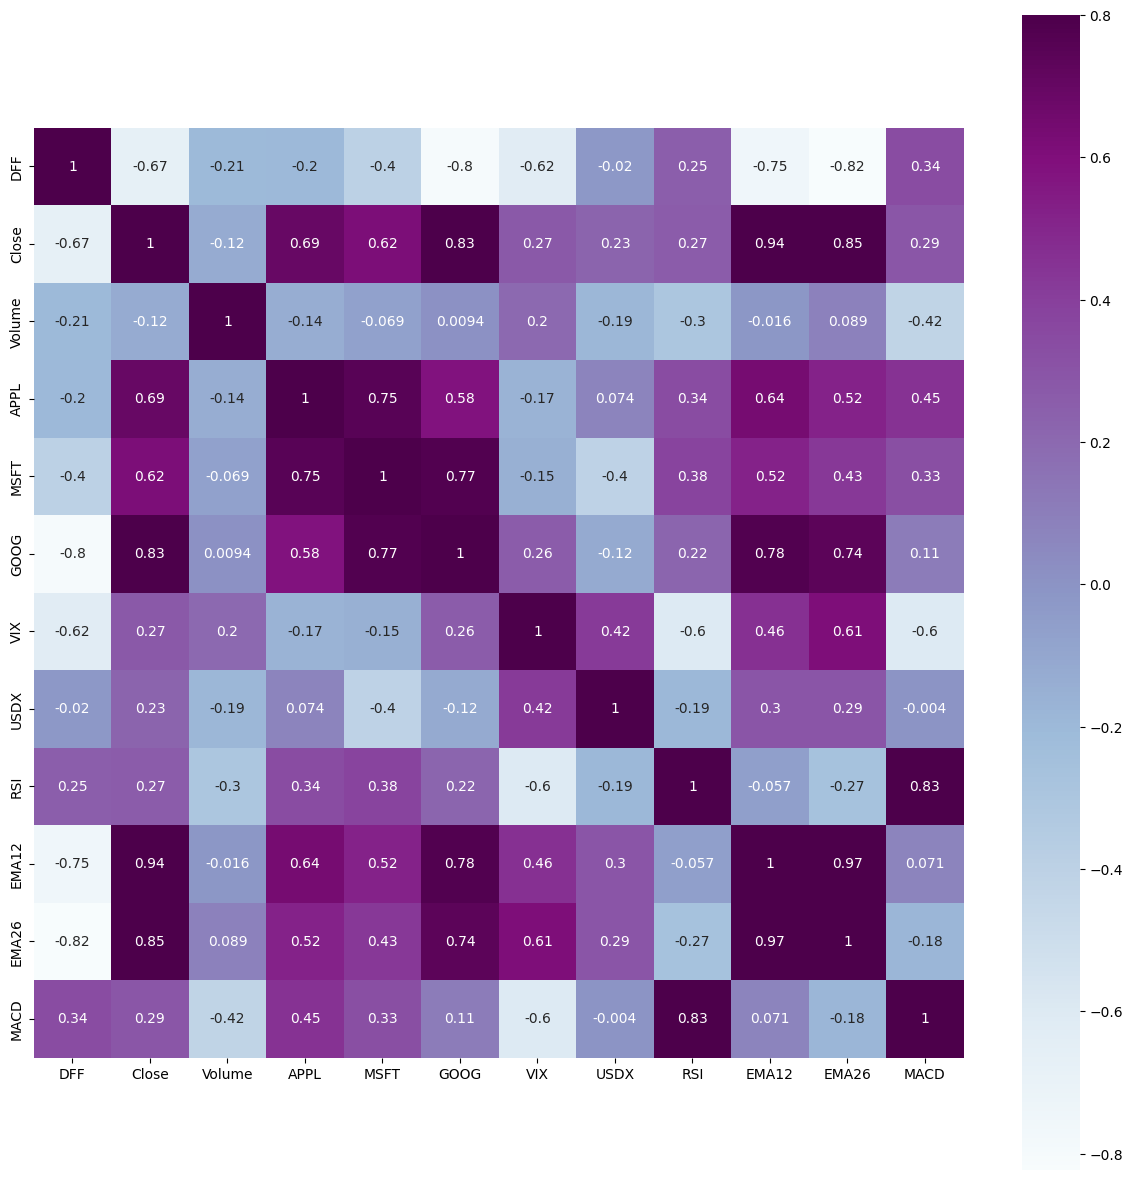

In [135]:
model_matrix_fig = Data.corr()
plt.figure(figsize=(15,15)) 
sns.heatmap(model_matrix_fig, vmax=.8, square=True, cmap="BuPu",annot=True);
plt.show()

In [136]:
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_Y, test_Y = y[:train_size], y[train_size:]

# Reshape the input data to 3D arrays
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2
]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss=MeanSquaredError(), optimizer=Adam())


In [137]:
import matplotlib.pyplot as plt


print(X.shape)
print()

(237, 11)



In [138]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model.fit(train_X, train_Y, epochs=100, batch_size=16, validation_data=(test_X, test_Y), callbacks=[early_stop], verbose=2, shuffle=False)

test_loss = model.evaluate(test_X, test_Y, verbose=0)
yhat = model.predict(test_X)

yhat = y_scaler.inverse_transform(yhat)
test_Y = y_scaler.inverse_transform(test_Y)

print('Test loss: ', test_loss)

mae = mean_absolute_error(test_Y, yhat)
rmse = np.sqrt(mean_squared_error(test_Y, yhat))
r2 = r2_score(test_Y, yhat)

print('MAE: ', mae)
print('RMSE: ', rmse)
print('R²: ', r2)

Epoch 1/100
12/12 - 5s - loss: 0.2311 - val_loss: 0.0141 - 5s/epoch - 457ms/step
Epoch 2/100
12/12 - 0s - loss: 0.1142 - val_loss: 0.0207 - 77ms/epoch - 6ms/step
Epoch 3/100
12/12 - 0s - loss: 0.0425 - val_loss: 0.0702 - 95ms/epoch - 8ms/step
Epoch 4/100
12/12 - 0s - loss: 0.0233 - val_loss: 0.0230 - 128ms/epoch - 11ms/step
Epoch 5/100
12/12 - 0s - loss: 0.0239 - val_loss: 0.0226 - 118ms/epoch - 10ms/step
Epoch 6/100
12/12 - 0s - loss: 0.0167 - val_loss: 0.0219 - 154ms/epoch - 13ms/step
Epoch 7/100
12/12 - 0s - loss: 0.0126 - val_loss: 0.0131 - 110ms/epoch - 9ms/step
Epoch 8/100
12/12 - 0s - loss: 0.0094 - val_loss: 0.0134 - 113ms/epoch - 9ms/step
Epoch 9/100
12/12 - 0s - loss: 0.0089 - val_loss: 0.0064 - 116ms/epoch - 10ms/step
Epoch 10/100
12/12 - 0s - loss: 0.0077 - val_loss: 0.0070 - 89ms/epoch - 7ms/step
Epoch 11/100
12/12 - 0s - loss: 0.0074 - val_loss: 0.0038 - 93ms/epoch - 8ms/step
Epoch 12/100
12/12 - 0s - loss: 0.0064 - val_loss: 0.0061 - 119ms/epoch - 10ms/step
Epoch 13/100


In [164]:

from pmdarima.arima import auto_arima
def generate_future_features_arima(X_data, n_steps):
    future_features = []
    for i in range(X_data.shape[1]):
        arima_model = auto_arima(X_data.iloc[:, i], suppress_warnings=True, seasonal=False, stepwise=True)
        forecast = arima_model.predict(n_periods=n_steps)
        future_features.append(forecast)
    return np.array(future_features).T     # List is 1D. So we converted to 2D with an array. But its column first then row [[1,2,3],[4,5,6],[7,8,9]]
# But for LSTM we need it to be row wise like Excel . so we transpose it to match LSTM dims

In [165]:
import pandas_market_calendars as mcal
from pandas.tseries.offsets import BDay

def generate_trading_days(start_date, n_days):
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.valid_days(start_date=start_date, end_date=start_date + BDay(n_days * 2)) # Business dayscounted. Multiplied by 2 to ensure we have enough business days
    return trading_days[:n_days]

n_future_days = 10
last_date = dates.iloc[-1].values[0]
future_dates = generate_trading_days(last_date, n_future_days)

print(future_dates)


2023-03-30T00:00:00.000000000
DatetimeIndex(['2023-03-30 00:00:00+00:00', '2023-03-31 00:00:00+00:00',
               '2023-04-03 00:00:00+00:00', '2023-04-04 00:00:00+00:00',
               '2023-04-05 00:00:00+00:00', '2023-04-06 00:00:00+00:00',
               '2023-04-10 00:00:00+00:00', '2023-04-11 00:00:00+00:00',
               '2023-04-12 00:00:00+00:00', '2023-04-13 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [166]:
# # Generate future feature values
# n_future_steps = 10
# future_dates = pd.date_range(dates.iloc[-1, 0], periods=n_future_steps + 1, closed='right')

# Get column names from the original DataFrame
column_names = X_data.columns


# Generate future feature values using ARIMA
future_features = generate_future_features_arima(X_data, n_future_days)

# Scale the future feature values
scaled_future_features = scaler.transform(future_features)


# Reshape the future feature values to a 3D array
scaled_future_features = scaled_future_features.reshape((scaled_future_features.shape[0], 1, scaled_future_features.shape[1]))

# Predict future closing prices
future_closing_prices = model.predict(scaled_future_features)

# Inverse transform the predicted closing prices
future_closing_prices = y_scaler.inverse_transform(future_closing_prices)

# Display the future closing prices
future_closing_prices_df = pd.DataFrame(future_closing_prices, index=future_dates, columns=['Predicted_Close'])
print(future_closing_prices_df)


Index(['DFF', 'Volume', 'APPL', 'MSFT', 'GOOG', 'VIX', 'USDX', 'RSI', 'EMA12',
       'EMA26', 'MACD'],
      dtype='object')
[[4.86524243e+00 5.53712608e+07 1.61839930e+02 2.84049988e+02
  1.01320000e+02 1.90681362e+01 1.02139999e+02 6.16924138e+01
  9.90604450e+01 9.77632875e+01 1.32633957e+00]
 [4.89852896e+00 5.61194074e+07 1.61343549e+02 2.84049988e+02
  1.01320000e+02 1.90681362e+01 1.02139999e+02 6.16924138e+01
  9.95425669e+01 9.81316973e+01 1.49825324e+00]
 [4.93010110e+00 5.64414834e+07 1.60869781e+02 2.84049988e+02
  1.01320000e+02 1.90681362e+01 1.02139999e+02 6.16924138e+01
  9.99626392e+01 9.85001071e+01 1.63628705e+00]
 [4.96017055e+00 5.65801366e+07 1.60417594e+02 2.84049988e+02
  1.01320000e+02 1.90681362e+01 1.02139999e+02 6.16924138e+01
  1.00328648e+02 9.88685169e+01 1.74711788e+00]
 [4.98892288e+00 5.66398266e+07 1.59986006e+02 2.84049988e+02
  1.01320000e+02 1.90681362e+01 1.02139999e+02 6.16924138e+01
  1.00647551e+02 9.92369266e+01 1.83610674e+00]
 [5.01652072e+

In [142]:
# import pickle

# # Save the model to a file
# with open('lstm_model_final.pkl', 'wb') as file:
#     pickle.dump(model, file)

# # Save the MinMaxScaler objects for X and y
# with open('x_scaler_final.pkl', 'wb') as file:
#     pickle.dump(scaler, file)

# with open('y_scaler_final.pkl', 'wb') as file:
#     pickle.dump(y_scaler, file)


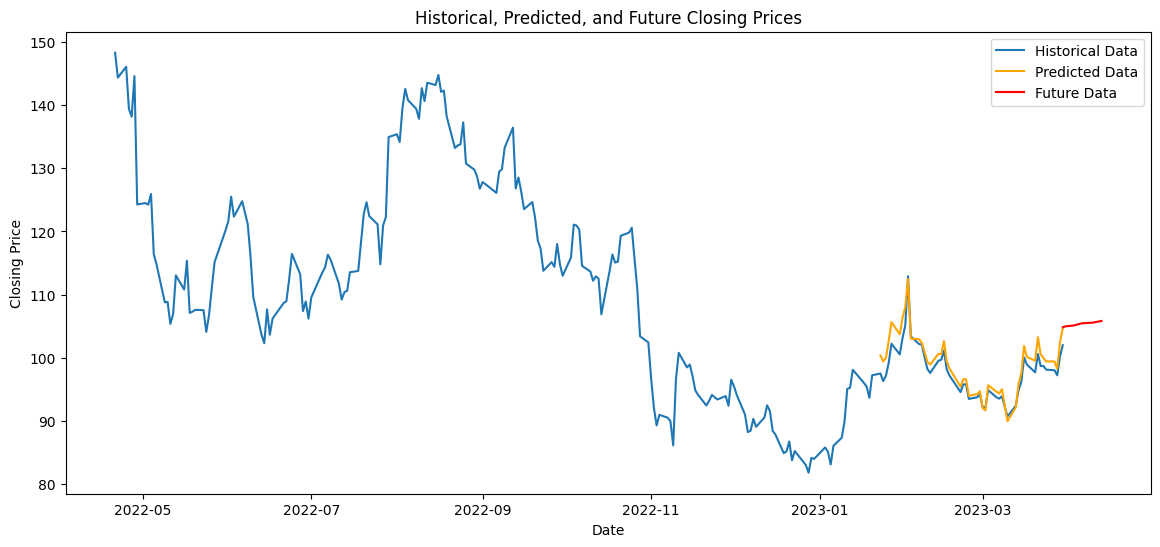

In [143]:


plt.figure(figsize=(14, 6))
plt.plot(dates, y_scaler.inverse_transform(y), label='Historical Data')
plt.plot(dates.iloc[-test_Y.shape[0]:], yhat, label='Predicted Data', color='orange')
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Historical, Predicted, and Future Closing Prices')
plt.legend()
plt.show()


In [172]:
print(yhat.shape)

(48, 1)


2/2 [==============================] - 0s 4ms/step


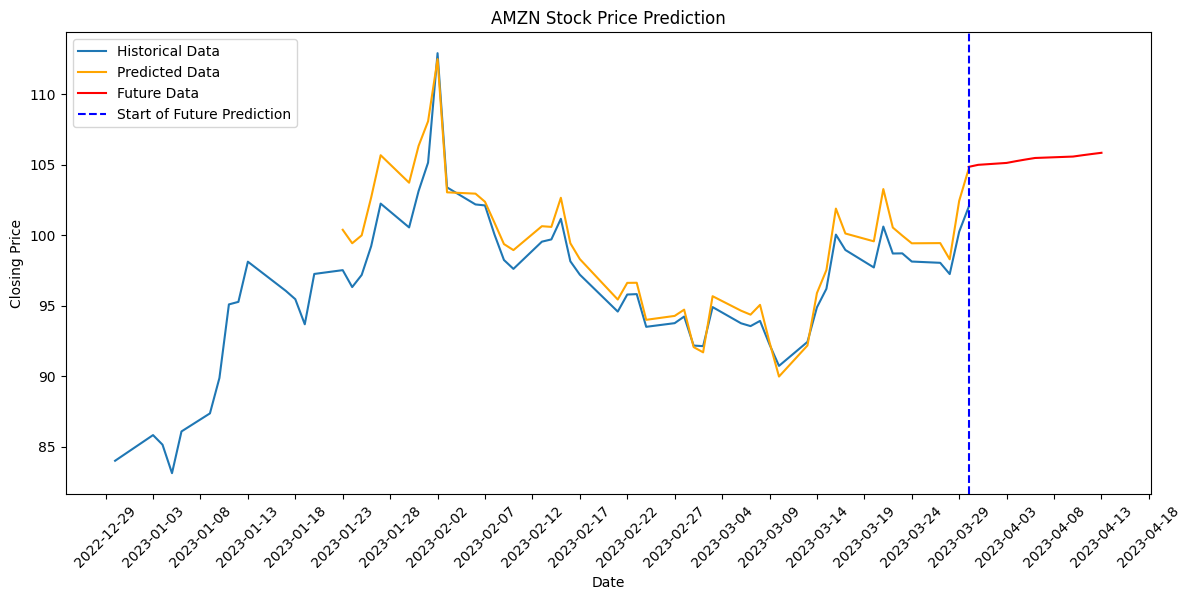

In [173]:
import matplotlib.dates as mdates
# Predict on the test set
test_Y_pred = model.predict(test_X)

# Filter the data for the last 3 months
n_months = 3
start_date = dates.iloc[-1][0] - pd.DateOffset(months=n_months)
mask = dates['Date'] >= start_date 
filtered_dates = dates[mask]
filtered_y = y_scaler.inverse_transform(y)[mask.to_numpy().reshape(-1)]  # reshaping to have a 1-1 mapping


# Filter the predicted data and extracted the DATES
predicted_mask = dates.iloc[-yhat.shape[0]:]['Date'] >= start_date # predicted_mask would have dates of the predicted data from the model only. 
#Since the max length is 48 after splitting so to go behind we use -48 as shape: so from 48days behind to the start. Also put in a condition that it should be greater than the 3 month limit. 
# Incase the days go way back before 3 months. And we created a T/F mask just like above
filtered_yhat = yhat
filtered_predicted_dates = dates.iloc[-yhat.shape[0]:][predicted_mask]

plt.figure(figsize=(14, 6))
plt.plot(filtered_dates['Date'], filtered_y, label='Historical Data')
plt.plot(filtered_predicted_dates['Date'], filtered_yhat, label='Predicted Data', color='orange')
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red')

# Draw a vertical line at the point of future prediction
plt.axvline(x=dates.iloc[-1][0], color='blue', linestyle='--', label='Start of Future Prediction')

# Display day-by-day dates on the x-axis
ax = plt.gca() # gca is used if you want to modify the property of the plots like axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Setting the format as YMD
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5)) # placing a tick every 5 days to ensure reduced cluttering
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AMZN Stock Price Prediction')
plt.legend()
plt.show()
